In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import (
    StratifiedKFold, train_test_split,
    GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.base import BaseEstimator, TransformerMixin

import optuna
from optuna.samplers import TPESampler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = list(X.columns)
        for col in self.cols:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.freq_maps[col])
            X_copy[col] = X_copy[col].fillna(np.mean(list(self.freq_maps[col].values)))
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols)

# DecisionTreeClassifier

In [5]:
df = pd.read_csv('./train.csv', index_col='id')

In [6]:
df_sample = df.sample(n=1_500_000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1_000_000,
    test_size=500_000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


In [ ]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", FrequencyEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    metrics = {
        'Method': name,
        'Precision': precision_corrected(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

# Обход возможного ZeroDivision в случае отсутствия предсказанных классов
def precision_corrected(y_true, y_pred):
    try:
        return precision_score(y_true, y_pred)
    except:
        return 0.0

In [9]:
results = []
conf_matrices = {}

In [10]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train, y_train)
metrics, cm = evaluate_pipeline(grid_search.best_estimator_, X_train, X_test, y_train, y_test, "GridSearchCV")
results.append(metrics)
conf_matrices["GridSearchCV"] = cm

In [11]:
param_dist = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': np.arange(2, 21),
    'classifier__min_samples_leaf': np.arange(1, 21),
    'classifier__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    base_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)
random_search.fit(X_train, y_train)
metrics, cm = evaluate_pipeline(random_search.best_estimator_, X_train, X_test, y_train, y_test, "RandomizedSearchCV")
results.append(metrics)
conf_matrices["RandomizedSearchCV"] = cm

In [13]:
def objective_optuna(trial):
    params = {
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 20),
        'classifier__min_samples_split': trial.suggest_int('classifier__min_samples_split', 2, 20),
        'classifier__min_samples_leaf': trial.suggest_int('classifier__min_samples_leaf', 1, 20),
        'classifier__max_features': trial.suggest_categorical('classifier__max_features', ['sqrt', 'log2', None]),
    }
    model = base_pipeline.set_params(**params)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds))
    return np.mean(scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective_optuna, n_trials=50)

optuna_pipeline = base_pipeline.set_params(**study.best_params)
optuna_pipeline.fit(X_train, y_train)
metrics, cm = evaluate_pipeline(optuna_pipeline, X_train, X_test, y_train, y_test, "Optuna")
results.append(metrics)
conf_matrices["Optuna"] = cm

[I 2025-12-06 11:09:40,604] A new study created in memory with name: no-name-abfc675d-c6aa-471a-9ed3-3f7aa1cd2613
[I 2025-12-06 11:09:48,021] Trial 0 finished with value: 0.43248744345246815 and parameters: {'classifier__max_depth': 9, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 15, 'classifier__max_features': 'sqrt'}. Best is trial 0 with value: 0.43248744345246815.
[I 2025-12-06 11:09:57,602] Trial 1 finished with value: 0.4134808851792169 and parameters: {'classifier__max_depth': 4, 'classifier__min_samples_split': 18, 'classifier__min_samples_leaf': 13, 'classifier__max_features': None}. Best is trial 0 with value: 0.43248744345246815.
[I 2025-12-06 11:10:16,484] Trial 2 finished with value: 0.4362922376226086 and parameters: {'classifier__max_depth': 17, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 4, 'classifier__max_features': None}. Best is trial 2 with value: 0.4362922376226086.
[I 2025-12-06 11:10:30,600] Trial 3 finished with v

In [ ]:
def objective_hyperopt(params):
    model = base_pipeline.set_params(**{
        'classifier__max_depth': int(params['max_depth']),
        'classifier__min_samples_split': int(params['min_samples_split']),
        'classifier__min_samples_leaf': int(params['min_samples_leaf']),
        'classifier__max_features': params['max_features']
    })
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds))
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

space = {
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

trials = Trials()
best = fmin(fn=objective_hyperopt,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

max_features_choice = ['sqrt', 'log2', None][best['max_features']]
hyperopt_params = {
    'classifier__max_depth': int(best['max_depth']),
    'classifier__min_samples_split': int(best['min_samples_split']),
    'classifier__min_samples_leaf': int(best['min_samples_leaf']),
    'classifier__max_features': max_features_choice
}

hyperopt_pipeline = base_pipeline.set_params(**hyperopt_params)
hyperopt_pipeline.fit(X_train, y_train)
metrics, cm = evaluate_pipeline(hyperopt_pipeline, X_train, X_test, y_train, y_test, "Hyperopt")
results.append(metrics)
conf_matrices["Hyperopt"] = cm

100%|██████████| 50/50 [07:49<00:00,  9.39s/trial, best loss: -0.4407380163312095] 


In [15]:
halving_search = HalvingGridSearchCV(
    base_pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)
halving_search.fit(X_train, y_train)
metrics, cm = evaluate_pipeline(halving_search.best_estimator_, X_train, X_test, y_train, y_test, "HalvingGridSearchCV")
results.append(metrics)
conf_matrices["HalvingGridSearchCV"] = cm

In [16]:
results_df = pd.DataFrame(results)
print("СВОДКА РЕЗУЛЬТАТОВ")
print("="*60)
print(results_df.round(4))

СВОДКА РЕЗУЛЬТАТОВ
                Method  Precision  Recall      F1  ROC-AUC
0         GridSearchCV     0.2882  0.9075  0.4375   0.8392
1   RandomizedSearchCV     0.2882  0.9075  0.4375   0.8392
2               Optuna     0.2879  0.9180  0.4384   0.8452
3             Hyperopt     0.2879  0.9180  0.4384   0.8452
4  HalvingGridSearchCV     0.2882  0.9075  0.4375   0.8392


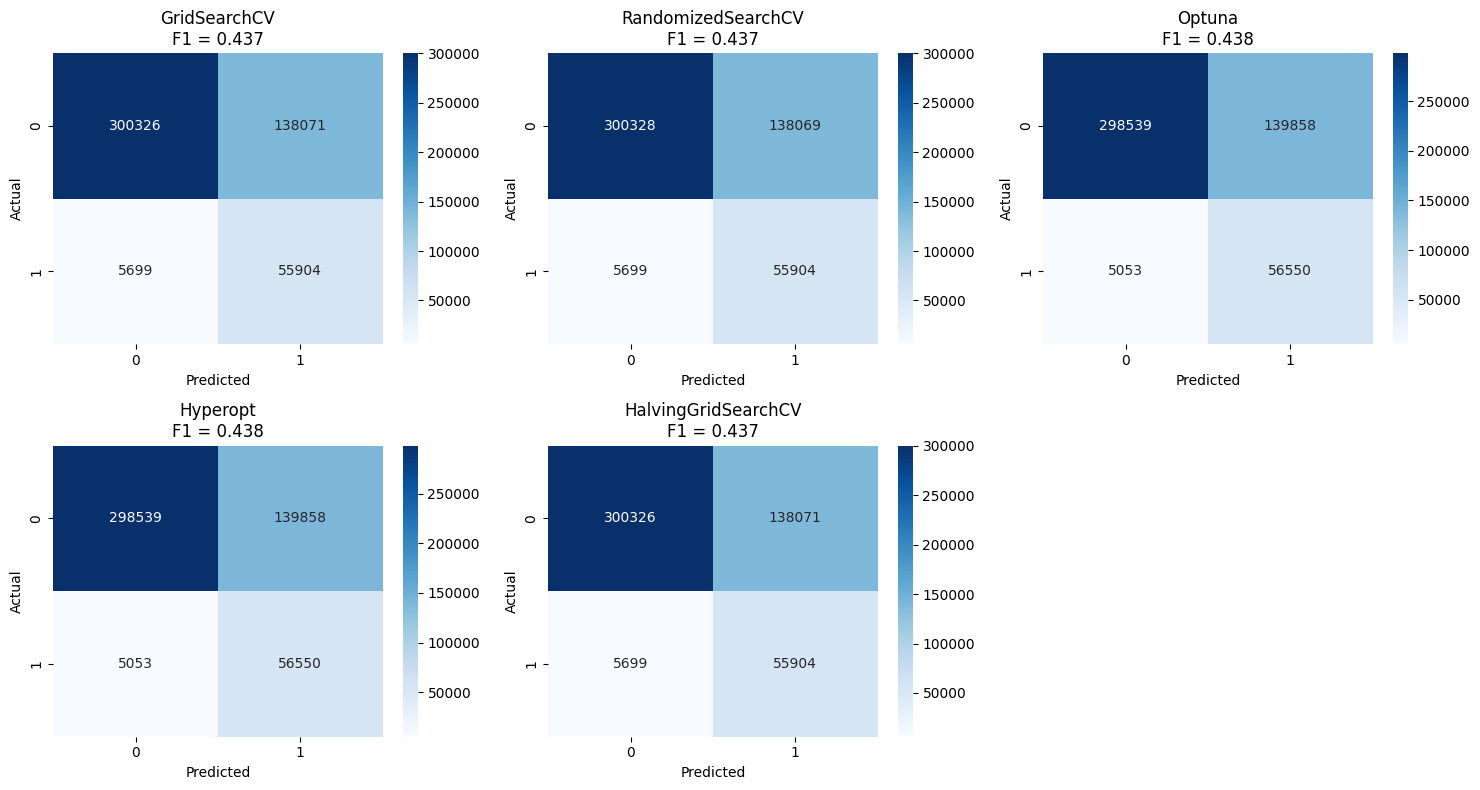

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

methods = list(conf_matrices.keys())
n = len(methods)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, method in enumerate(methods):
    cm = conf_matrices[method]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    f1_val = results_df.loc[results_df['Method'] == method, 'F1'].values[0]
    axes[i].set_title(f'{method}\nF1 = {f1_val:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Выводы:

- Модель очень хорошо находит True Positives - Recall = 0.91
- Но также очень много False Positives - Precision = 0.29

**Обоснование выбора F1-score**: для задачи предсказания отклика на предложение доп. страховки оптимальная метрика для подбора гиперпараметров - F1-score, так как она фокусируются на качестве предсказания положительного класса (Response = 1) и устойчива к дисбалансу.

**Обоснование одинаковых результатов**:
- Все методы оптимизации почти равнозначны
- Пространство гиперпараметров очень маленькое
- Возможно переобчение модели

**Итог гипероптимизации:**
- Базовый уровень - GridSearchCV
- Продвинутый уровень - HalvingGridSearchCV

**Возникающие проблемы:**
- Дерево решений плохо работает с несбалансированными данными и склонно к переобучению
- Оптимизация гиперпараметров не дала существенного улучшения, за исключением небольшого роста ROC-AUC у Optuna/Hyperopt, но ценой большего времени